In [1]:
import time
import pulp
import numpy as np
import simplex_solver
import scipy
import warnings
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output


def create_problem(max_val, n, m):
    A = np.random.randint(max_val, size=n * m).reshape((n, m))
    x_ = np.random.randint(max_val, size=m)
    delta = np.random.randint(max_val, size=n)
    b = A @ x_ + delta
    c = np.random.randint(max_val, size=m)
    A = np.append(A, np.identity(A.shape[0]), axis=1)
    c = np.append(c, np.zeros(A.shape[0]))
    return A, b, c


def create_pulp_lp(A, b, c):
    prob_pulp = pulp.LpProblem("pulp", pulp.LpMaximize)
    x = pulp.LpVariable.matrix(
        "x", range(A.shape[1]), 0, None, pulp.LpContinuous
    )
    prob_pulp += c @ x
    for lhs, rhs in zip(A @ x, b):
        prob_pulp += lhs == rhs
    return prob_pulp

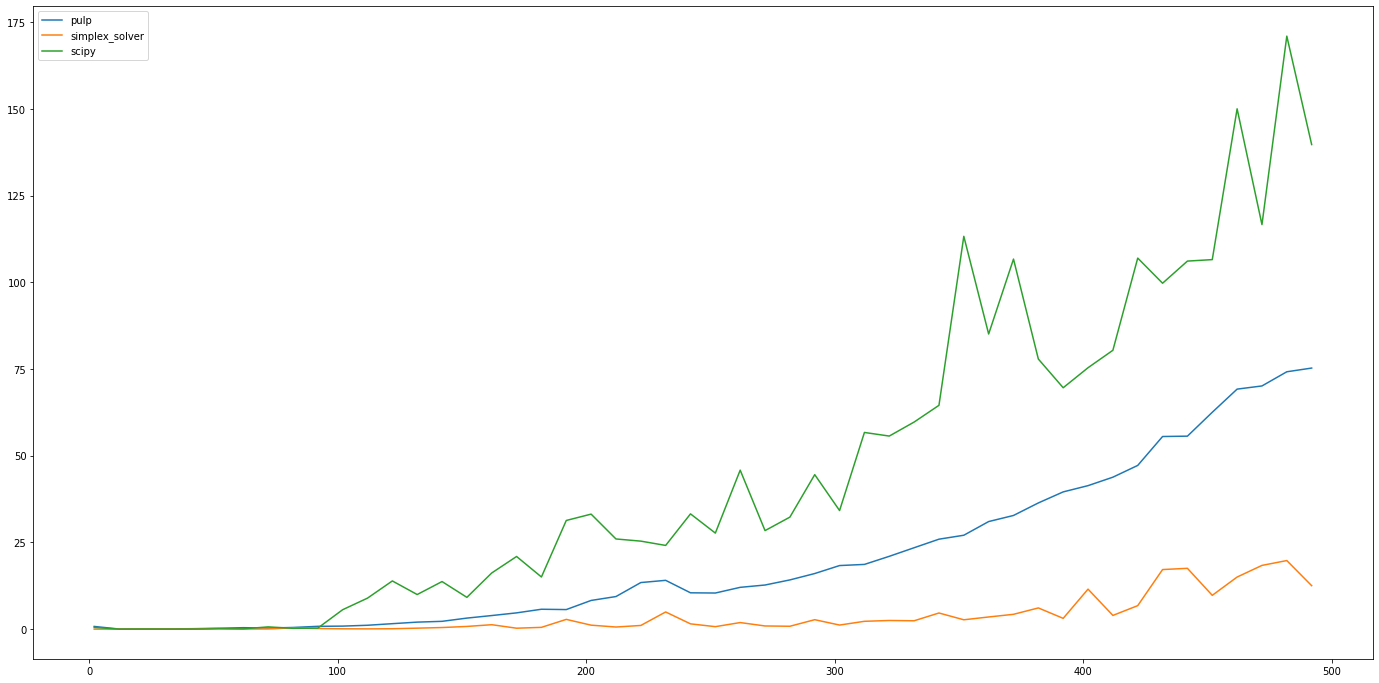

In [2]:
np.random.seed(42)
max_val = 100

x = []
pulp_times = []
j_times = []
scipy_times = []
objs = []


fig, ax = plt.subplots()
fig.set_size_inches([24, 12])
(line1,) = ax.plot(x, pulp_times, label="pulp_times")
(line2,) = ax.plot(x, j_times, label="j_times")
(line3,) = ax.plot(x, scipy_times, label="scipy_times")
plt.legend(["pulp", "simplex_solver", "scipy"])

for n in range(2, 500, 10):
    m = n
    A, b, c = create_problem(max_val, n, m)

    t0 = time.monotonic()
    prob_pulp = create_pulp_lp(A, b, c)
    status = prob_pulp.solve(pulp.PULP_CBC_CMD(msg=0))
    obj_pulp = prob_pulp.objective.value()
    t1 = time.monotonic()
    pulp_times.append(t1 - t0)

    prob = simplex_solver.LpProblem(A, b, c)
    prob.set_initial_basis()
    prob.primal_simplex(1000000, log_iterations=False)
    obj_j = prob.obj
    t2 = time.monotonic()
    j_times.append(t2 - t1)

    res = scipy.optimize.linprog(
        -c,
        A_ub=A,
        b_ub=b,
        method="revised simplex",
    )
    obj_sc = res.fun
    t3 = time.monotonic()
    scipy_times.append(t3 - t2)

    x.append(n)
    line1.set_data(x, pulp_times)
    line2.set_data(x, j_times)
    line3.set_data(x, scipy_times)

    ax.relim()
    ax.autoscale_view()

    print(obj_pulp, obj_j, obj_sc, end="")
    display(fig)
    clear_output(wait=True)
